# PyTorch Faster R-CNN

Main model trained and tested on a small sample of 135 images.

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

### Dependencies

Tested using torch.__version__ = 1.8.0. To install other dependencies run:

```bash
$ pip install --upgrade pip
$ pip install torchvision
$ pip install cython
$ pip install pycocotools
$ pip install torch-summary
```

### Helper functions

We will import some helper functions to simplify training and evaluating detection model. We will use `/references/detection/{engine, utils, transforms}.py` from `pytorch.vision` repository:

```bash
$ git clone https://github.com/pytorch/vision.git
$ mkdir pytorch-helpers
$ cd vision
$ git checkout v0.3.0
$ cp references/detection/utils.py ../pytorch-helpers/
$ cp references/detection/transforms.py ../pytorch-helpers/
$ cp references/detection/coco_eval.py ../pytorch-helpers/
$ cp references/detection/engine.py ../pytorch-helpers/
$ cp references/detection/coco_utils.py ../pytorch-helpers/
$ cd ../pytorch-helpers/
$ chmod +x *
```

### Imports

In [4]:
import os
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

In [3]:
import scipy.io
import torch
import torch.utils.data
import torchvision

In [4]:
# ../src/pytorch-helpers/
module_path = os.path.abspath(os.path.join('../src/pytorch-helpers/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [7]:
base_model_path = '../src/main-model/'

module_path = os.path.abspath(os.path.join(base_model_path))
if module_path not in sys.path:
    sys.path.append(module_path)

import fasterutils
import fasterrcnn

## Data

In [8]:
imgs_path = '../data/sample-dataset/'

In [9]:
anno_dict = np.load('../data/anno-big.npy', allow_pickle='TRUE').item()
imgs_person = list(anno_dict.keys())
len(imgs_person)

135

In [10]:
imgs = list(anno_dict.keys())
len(imgs)

135

In [11]:
i = 0
img_name = imgs_person[i]
img = Image.open(imgs_path + img_name)
bboxes = anno_dict[img_name]

In [12]:
plt.rcParams['figure.figsize'] = [12, 8]

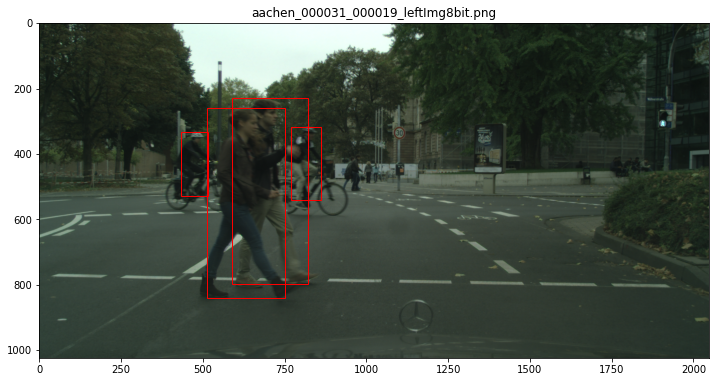

In [13]:
fig, ax = plt.subplots()
ax.imshow(img)

for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.title(img_name)
plt.show()

In [14]:
img_np = np.array(img)
H, W = img_np.shape[:2]
H, W

(1024, 2048)

## Prepare Torch.utils.data.Dataset class for this dataset

In [15]:
img_paths = [(imgs_path + img_name) for img_name in imgs]
imgs1 = [img_path.split('/')[-1] for img_path in img_paths]
imgs2 = list(anno_dict.keys())
assert imgs1 == imgs2, 'Problems'
assert imgs == imgs1, 'Problems'

In [16]:
dataset = fasterrcnn.Dataset(img_paths, imgs, anno_dict)

In [17]:
## test it
data = []
for i in range(len(dataset)):
    data.append(dataset[i])

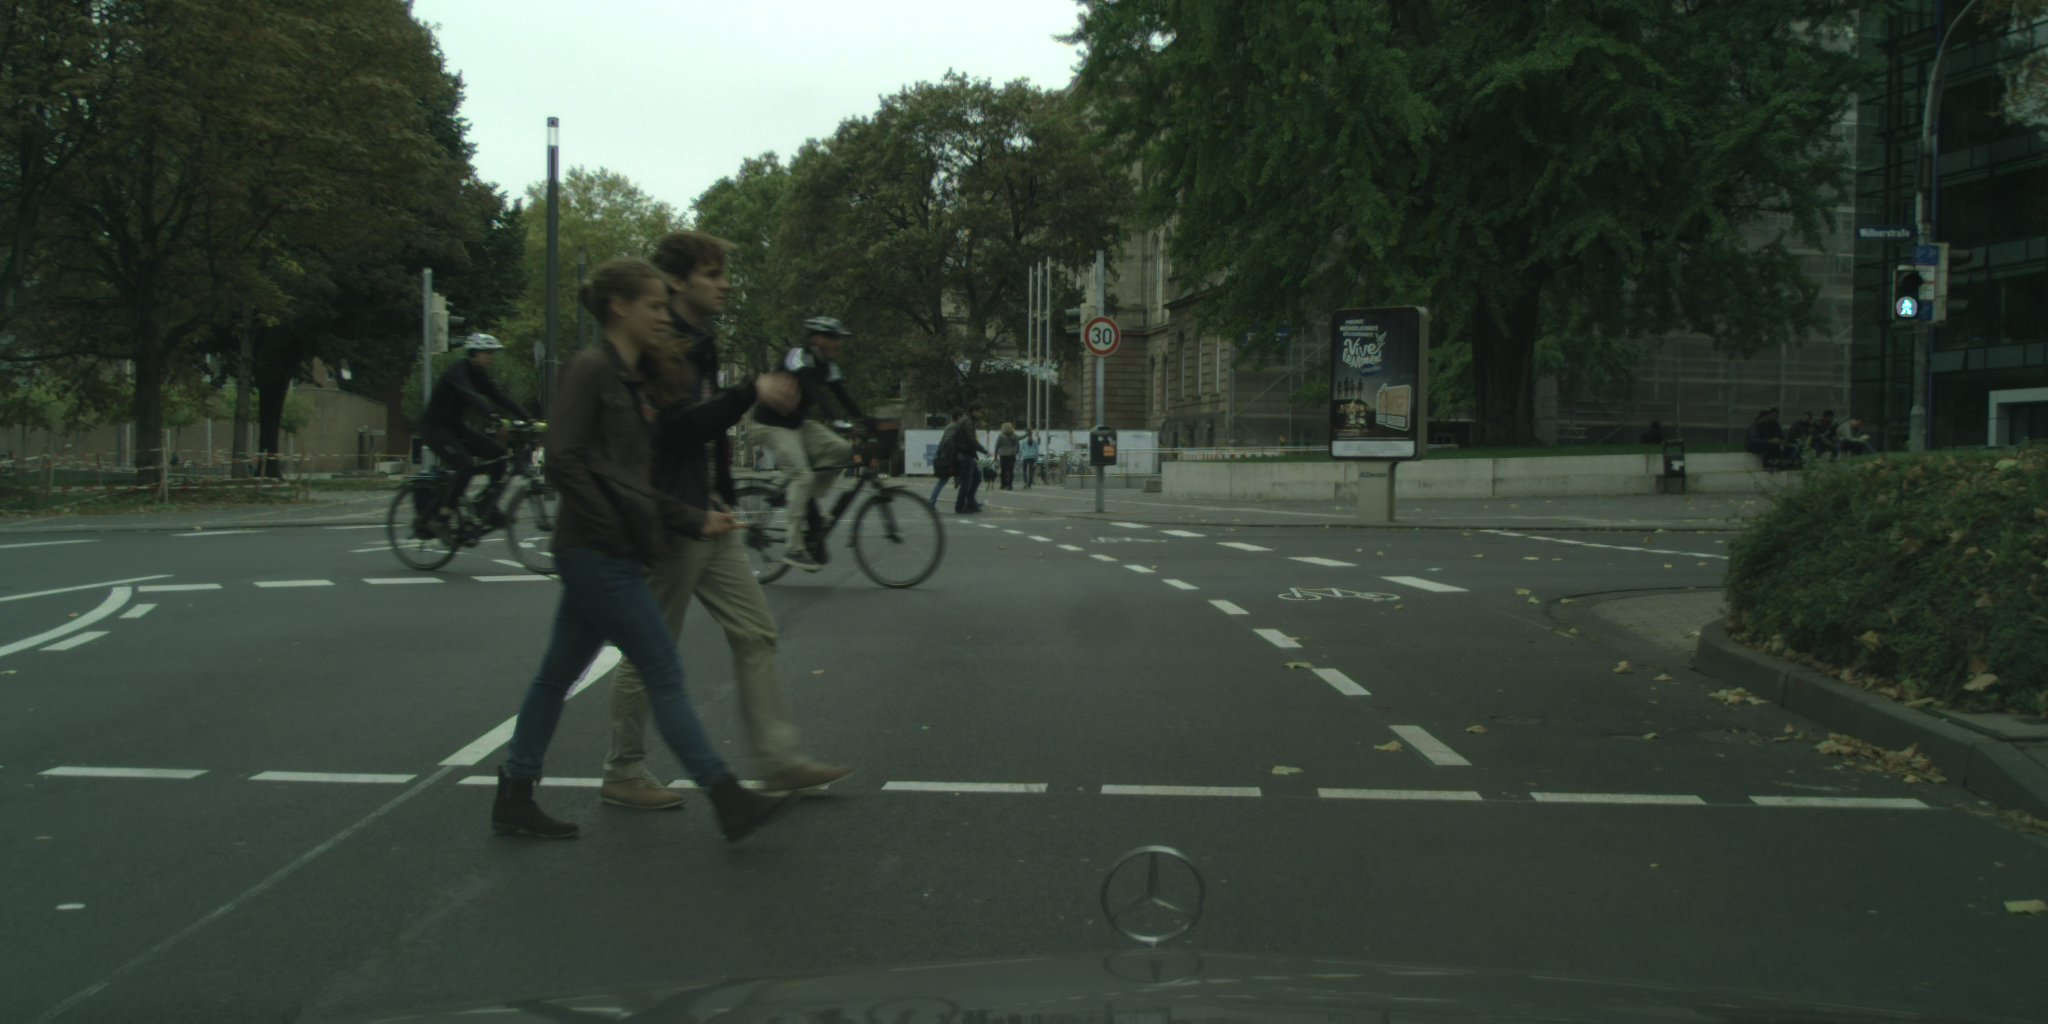

In [18]:
data[0][0]

## Train the model

We do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Faster R-CNN model.

In [19]:
## split the dataset into train and test
dataset = fasterrcnn.Dataset(
    img_paths,
    imgs,
    anno_dict, 
    fasterutils.get_transform(train=True))

dataset_test = fasterrcnn.Dataset(
    img_paths, 
    imgs,
    anno_dict, 
    fasterutils.get_transform(train=False))

## permute the indices
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

In [20]:
## check it
print(len(indices), len(dataset_test))
print(dataset[0],  dataset_test[0])

135 135
(tensor([[[0.1529, 0.1686, 0.1294,  ..., 0.1804, 0.1804, 0.1647],
         [0.1333, 0.1412, 0.1294,  ..., 0.1569, 0.1529, 0.1608],
         [0.1216, 0.1255, 0.1373,  ..., 0.1451, 0.1373, 0.1686],
         ...,
         [0.1765, 0.1725, 0.1725,  ..., 0.1451, 0.1490, 0.1451],
         [0.1765, 0.1725, 0.1725,  ..., 0.1529, 0.1490, 0.1451],
         [0.1765, 0.1725, 0.1725,  ..., 0.1529, 0.1529, 0.1490]],

        [[0.1961, 0.2157, 0.2000,  ..., 0.2235, 0.2235, 0.2157],
         [0.1725, 0.1765, 0.1725,  ..., 0.2078, 0.2157, 0.2235],
         [0.1490, 0.1608, 0.1686,  ..., 0.1961, 0.2039, 0.2392],
         ...,
         [0.2314, 0.2314, 0.2353,  ..., 0.2000, 0.2039, 0.2000],
         [0.2314, 0.2314, 0.2353,  ..., 0.2000, 0.2000, 0.1961],
         [0.2314, 0.2314, 0.2353,  ..., 0.2000, 0.2000, 0.2000]],

        [[0.1412, 0.1608, 0.1490,  ..., 0.1569, 0.1608, 0.1490],
         [0.1176, 0.1255, 0.1255,  ..., 0.1412, 0.1529, 0.1608],
         [0.1059, 0.1137, 0.1216,  ..., 0.1412, 0

In [21]:
## define train and test sets
dataset = torch.utils.data.Subset(dataset, indices[:-36])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-36:])

## define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [22]:
## check the results
print('Batch size = %d' % (data_loader.batch_size))

data_loader.dataset[0], data_loader.dataset[0]

Batch size = 2


((tensor([[[0.4275, 0.4157, 0.4039,  ..., 0.0000, 0.0863, 0.1804],
           [0.3843, 0.3804, 0.3804,  ..., 0.0000, 0.0902, 0.1804],
           [0.3922, 0.3882, 0.3843,  ..., 0.0000, 0.0941, 0.1765],
           ...,
           [0.2667, 0.2627, 0.2706,  ..., 0.1412, 0.1373, 0.1373],
           [0.2667, 0.2627, 0.2706,  ..., 0.1412, 0.1373, 0.1373],
           [0.2667, 0.2627, 0.2706,  ..., 0.1412, 0.1412, 0.1373]],
  
          [[0.4745, 0.4627, 0.4510,  ..., 0.0000, 0.0863, 0.1569],
           [0.4353, 0.4353, 0.4314,  ..., 0.0000, 0.0902, 0.1569],
           [0.4431, 0.4392, 0.4392,  ..., 0.0000, 0.0941, 0.1569],
           ...,
           [0.3137, 0.3098, 0.3176,  ..., 0.1647, 0.1608, 0.1569],
           [0.3137, 0.3098, 0.3176,  ..., 0.1647, 0.1608, 0.1569],
           [0.3137, 0.3098, 0.3176,  ..., 0.1647, 0.1608, 0.1569]],
  
          [[0.4275, 0.4157, 0.4039,  ..., 0.0000, 0.0667, 0.1412],
           [0.3451, 0.3451, 0.3490,  ..., 0.0000, 0.0706, 0.1412],
           [0.3686, 0.

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [24]:
model = fasterutils.get_model()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [25]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [26]:
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Let's train the model for 5 epochs, evaluating at the end of every epoch.

In [ ]:
num_epochs = 5

tstart = time.time()
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    
tend = time.time()    

Epoch: [0]  [ 0/50]  eta: 0:01:13  lr: 0.000107  loss: 1.2254 (1.2254)  loss_classifier: 0.5643 (0.5643)  loss_box_reg: 0.5329 (0.5329)  loss_objectness: 0.1185 (0.1185)  loss_rpn_box_reg: 0.0097 (0.0097)  time: 1.4667  data: 0.6864  max mem: 994
Epoch: [0]  [10/50]  eta: 0:00:32  lr: 0.001126  loss: 1.2012 (1.1337)  loss_classifier: 0.4928 (0.4685)  loss_box_reg: 0.6060 (0.5767)  loss_objectness: 0.0576 (0.0662)  loss_rpn_box_reg: 0.0149 (0.0223)  time: 0.8244  data: 0.0745  max mem: 1052
Epoch: [0]  [20/50]  eta: 0:00:23  lr: 0.002146  loss: 0.8886 (0.9352)  loss_classifier: 0.3166 (0.3647)  loss_box_reg: 0.4533 (0.4957)  loss_objectness: 0.0461 (0.0577)  loss_rpn_box_reg: 0.0140 (0.0171)  time: 0.7601  data: 0.0134  max mem: 1052
Epoch: [0]  [30/50]  eta: 0:00:15  lr: 0.003165  loss: 0.5960 (0.8101)  loss_classifier: 0.1651 (0.2943)  loss_box_reg: 0.3659 (0.4431)  loss_objectness: 0.0440 (0.0564)  loss_rpn_box_reg: 0.0092 (0.0163)  time: 0.7616  data: 0.0140  max mem: 1052
Epoch: [0

***Training takes too long on a CPU, you need the GPU to train this. See `Main-Model.pdf`, I'm copy pasting here: ***

```
Epoch: [0]  [ 0/50]  eta: 0:01:10  lr: 0.000107  loss: 0.4384 (0.4384)  loss_classifier: 0.1098 (0.1098)  loss_box_reg: 0.2941 (0.2941)  loss_objectness: 0.0198 (0.0198)  loss_rpn_box_reg: 0.0147 (0.0147)  time: 1.4198  data: 0.6559  max mem: 1052
Epoch: [0]  [10/50]  eta: 0:00:32  lr: 0.001126  loss: 0.4384 (0.4295)  loss_classifier: 0.1167 (0.1246)  loss_box_reg: 0.2283 (0.2544)  loss_objectness: 0.0293 (0.0363)  loss_rpn_box_reg: 0.0144 (0.0141)  time: 0.8223  data: 0.0728  max mem: 1052
Epoch: [0]  [20/50]  eta: 0:00:23  lr: 0.002146  loss: 0.3653 (0.3880)  loss_classifier: 0.1021 (0.1088)  loss_box_reg: 0.2095 (0.2346)  loss_objectness: 0.0252 (0.0313)  loss_rpn_box_reg: 0.0084 (0.0132)  time: 0.7623  data: 0.0140  max mem: 1052
Epoch: [0]  [30/50]  eta: 0:00:15  lr: 0.003165  loss: 0.3219 (0.3689)  loss_classifier: 0.0830 (0.1016)  loss_box_reg: 0.1967 (0.2241)  loss_objectness: 0.0219 (0.0313)  loss_rpn_box_reg: 0.0077 (0.0119)  time: 0.7629  data: 0.0138  max mem: 1052
Epoch: [0]  [40/50]  eta: 0:00:07  lr: 0.004184  loss: 0.3512 (0.3754)  loss_classifier: 0.0996 (0.1045)  loss_box_reg: 0.2211 (0.2296)  loss_objectness: 0.0185 (0.0292)  loss_rpn_box_reg: 0.0086 (0.0120)  time: 0.7644  data: 0.0142  max mem: 1052
Epoch: [0]  [49/50]  eta: 0:00:00  lr: 0.005000  loss: 0.3512 (0.3669)  loss_classifier: 0.0996 (0.1033)  loss_box_reg: 0.2191 (0.2248)  loss_objectness: 0.0179 (0.0273)  loss_rpn_box_reg: 0.0086 (0.0115)  time: 0.7453  data: 0.0138  max mem: 1052
Epoch: [0] Total time: 0:00:38 (0.7700 s / it)
creating index...
index created!
Test:  [ 0/36]  eta: 0:00:28  model_time: 0.3264 (0.3264)  evaluator_time: 0.0223 (0.0223)  time: 0.7817  data: 0.4268  max mem: 1052
Test:  [35/36]  eta: 0:00:00  model_time: 0.3429 (0.3416)  evaluator_time: 0.0041 (0.0083)  time: 0.3638  data: 0.0074  max mem: 1052
Test: Total time: 0:00:13 (0.3755 s / it)
Averaged stats: model_time: 0.3429 (0.3416)  evaluator_time: 0.0041 (0.0083)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.561
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.483
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.486
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.552
Epoch: [1]  [ 0/50]  eta: 0:01:10  lr: 0.005000  loss: 0.1378 (0.1378)  loss_classifier: 0.0323 (0.0323)  loss_box_reg: 0.0948 (0.0948)  loss_objectness: 0.0093 (0.0093)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 1.4003  data: 0.6565  max mem: 1052
Epoch: [1]  [10/50]  eta: 0:00:32  lr: 0.005000  loss: 0.3661 (0.3443)  loss_classifier: 0.0911 (0.0927)  loss_box_reg: 0.2323 (0.2109)  loss_objectness: 0.0199 (0.0286)  loss_rpn_box_reg: 0.0095 (0.0121)  time: 0.8205  data: 0.0720  max mem: 1052
Epoch: [1]  [20/50]  eta: 0:00:23  lr: 0.005000  loss: 0.3661 (0.3581)  loss_classifier: 0.0904 (0.0954)  loss_box_reg: 0.2323 (0.2239)  loss_objectness: 0.0199 (0.0243)  loss_rpn_box_reg: 0.0103 (0.0145)  time: 0.7638  data: 0.0140  max mem: 1052
Epoch: [1]  [30/50]  eta: 0:00:15  lr: 0.005000  loss: 0.3525 (0.3543)  loss_classifier: 0.0904 (0.0967)  loss_box_reg: 0.2360 (0.2236)  loss_objectness: 0.0139 (0.0210)  loss_rpn_box_reg: 0.0098 (0.0130)  time: 0.7644  data: 0.0139  max mem: 1052
Epoch: [1]  [40/50]  eta: 0:00:07  lr: 0.005000  loss: 0.3004 (0.3424)  loss_classifier: 0.0882 (0.0954)  loss_box_reg: 0.1892 (0.2151)  loss_objectness: 0.0136 (0.0199)  loss_rpn_box_reg: 0.0069 (0.0120)  time: 0.7642  data: 0.0132  max mem: 1052
Epoch: [1]  [49/50]  eta: 0:00:00  lr: 0.005000  loss: 0.2633 (0.3309)  loss_classifier: 0.0787 (0.0939)  loss_box_reg: 0.1468 (0.2061)  loss_objectness: 0.0136 (0.0200)  loss_rpn_box_reg: 0.0058 (0.0110)  time: 0.7456  data: 0.0136  max mem: 1052
Epoch: [1] Total time: 0:00:38 (0.7704 s / it)
creating index...
index created!
Test:  [ 0/36]  eta: 0:00:30  model_time: 0.3245 (0.3245)  evaluator_time: 0.0173 (0.0173)  time: 0.8354  data: 0.4867  max mem: 1052
Test:  [35/36]  eta: 0:00:00  model_time: 0.3438 (0.3418)  evaluator_time: 0.0041 (0.0078)  time: 0.3634  data: 0.0071  max mem: 1052
Test: Total time: 0:00:13 (0.3768 s / it)
Averaged stats: model_time: 0.3438 (0.3418)  evaluator_time: 0.0041 (0.0078)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.827
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.580
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.502
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.513
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.572
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.572
Epoch: [2]  [ 0/50]  eta: 0:01:09  lr: 0.000500  loss: 0.4921 (0.4921)  loss_classifier: 0.1174 (0.1174)  loss_box_reg: 0.3180 (0.3180)  loss_objectness: 0.0442 (0.0442)  loss_rpn_box_reg: 0.0125 (0.0125)  time: 1.3866  data: 0.6355  max mem: 1052
Epoch: [2]  [10/50]  eta: 0:00:32  lr: 0.000500  loss: 0.2357 (0.2945)  loss_classifier: 0.0772 (0.0866)  loss_box_reg: 0.1385 (0.1840)  loss_objectness: 0.0109 (0.0165)  loss_rpn_box_reg: 0.0074 (0.0074)  time: 0.8191  data: 0.0708  max mem: 1052
Epoch: [2]  [20/50]  eta: 0:00:23  lr: 0.000500  loss: 0.3102 (0.3245)  loss_classifier: 0.0775 (0.0964)  loss_box_reg: 0.1981 (0.1995)  loss_objectness: 0.0102 (0.0200)  loss_rpn_box_reg: 0.0071 (0.0086)  time: 0.7636  data: 0.0142  max mem: 1052
Epoch: [2]  [30/50]  eta: 0:00:15  lr: 0.000500  loss: 0.3010 (0.3002)  loss_classifier: 0.0857 (0.0899)  loss_box_reg: 0.1823 (0.1848)  loss_objectness: 0.0102 (0.0174)  loss_rpn_box_reg: 0.0064 (0.0082)  time: 0.7644  data: 0.0142  max mem: 1052
Epoch: [2]  [40/50]  eta: 0:00:07  lr: 0.000500  loss: 0.2433 (0.2904)  loss_classifier: 0.0653 (0.0859)  loss_box_reg: 0.1432 (0.1792)  loss_objectness: 0.0123 (0.0163)  loss_rpn_box_reg: 0.0049 (0.0090)  time: 0.7642  data: 0.0140  max mem: 1052
Epoch: [2]  [49/50]  eta: 0:00:00  lr: 0.000500  loss: 0.2604 (0.2976)  loss_classifier: 0.0795 (0.0874)  loss_box_reg: 0.1537 (0.1854)  loss_objectness: 0.0107 (0.0156)  loss_rpn_box_reg: 0.0064 (0.0093)  time: 0.7461  data: 0.0135  max mem: 1052
Epoch: [2] Total time: 0:00:38 (0.7702 s / it)
creating index...
index created!
Test:  [ 0/36]  eta: 0:00:27  model_time: 0.3283 (0.3283)  evaluator_time: 0.0166 (0.0166)  time: 0.7739  data: 0.4233  max mem: 1052
Test:  [35/36]  eta: 0:00:00  model_time: 0.3422 (0.3417)  evaluator_time: 0.0040 (0.0076)  time: 0.3632  data: 0.0075  max mem: 1052
Test: Total time: 0:00:13 (0.3750 s / it)
Averaged stats: model_time: 0.3422 (0.3417)  evaluator_time: 0.0040 (0.0076)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.527
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.832
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.588
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.528
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.530
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.593
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.593
Epoch: [3]  [ 0/50]  eta: 0:01:09  lr: 0.000500  loss: 0.2322 (0.2322)  loss_classifier: 0.0631 (0.0631)  loss_box_reg: 0.1552 (0.1552)  loss_objectness: 0.0088 (0.0088)  loss_rpn_box_reg: 0.0052 (0.0052)  time: 1.3892  data: 0.6419  max mem: 1052
Epoch: [3]  [10/50]  eta: 0:00:32  lr: 0.000500  loss: 0.2893 (0.2993)  loss_classifier: 0.0777 (0.0851)  loss_box_reg: 0.1961 (0.1932)  loss_objectness: 0.0133 (0.0111)  loss_rpn_box_reg: 0.0071 (0.0099)  time: 0.8219  data: 0.0722  max mem: 1052
Epoch: [3]  [20/50]  eta: 0:00:23  lr: 0.000500  loss: 0.2845 (0.2775)  loss_classifier: 0.0777 (0.0795)  loss_box_reg: 0.1840 (0.1794)  loss_objectness: 0.0114 (0.0109)  loss_rpn_box_reg: 0.0062 (0.0078)  time: 0.7649  data: 0.0147  max mem: 1052
Epoch: [3]  [30/50]  eta: 0:00:15  lr: 0.000500  loss: 0.2015 (0.2803)  loss_classifier: 0.0672 (0.0825)  loss_box_reg: 0.1392 (0.1757)  loss_objectness: 0.0114 (0.0142)  loss_rpn_box_reg: 0.0044 (0.0079)  time: 0.7646  data: 0.0139  max mem: 1052
Epoch: [3]  [40/50]  eta: 0:00:07  lr: 0.000500  loss: 0.2079 (0.2847)  loss_classifier: 0.0691 (0.0845)  loss_box_reg: 0.1299 (0.1771)  loss_objectness: 0.0118 (0.0149)  loss_rpn_box_reg: 0.0063 (0.0082)  time: 0.7656  data: 0.0140  max mem: 1052
Epoch: [3]  [49/50]  eta: 0:00:00  lr: 0.000500  loss: 0.2791 (0.2869)  loss_classifier: 0.0867 (0.0852)  loss_box_reg: 0.1717 (0.1783)  loss_objectness: 0.0107 (0.0146)  loss_rpn_box_reg: 0.0063 (0.0089)  time: 0.7470  data: 0.0139  max mem: 1052
Epoch: [3] Total time: 0:00:38 (0.7715 s / it)
creating index...
index created!
Test:  [ 0/36]  eta: 0:00:28  model_time: 0.3286 (0.3286)  evaluator_time: 0.0296 (0.0296)  time: 0.7847  data: 0.4203  max mem: 1052
Test:  [35/36]  eta: 0:00:00  model_time: 0.3427 (0.3443)  evaluator_time: 0.0038 (0.0102)  time: 0.3634  data: 0.0077  max mem: 1052
Test: Total time: 0:00:13 (0.3852 s / it)
Averaged stats: model_time: 0.3427 (0.3443)  evaluator_time: 0.0038 (0.0102)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.836
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.608
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.536
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.600
Epoch: [4]  [ 0/50]  eta: 0:01:10  lr: 0.000500  loss: 0.0881 (0.0881)  loss_classifier: 0.0386 (0.0386)  loss_box_reg: 0.0479 (0.0479)  loss_objectness: 0.0011 (0.0011)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.4078  data: 0.6561  max mem: 1052
Epoch: [4]  [10/50]  eta: 0:00:32  lr: 0.000500  loss: 0.2925 (0.3030)  loss_classifier: 0.0884 (0.0861)  loss_box_reg: 0.2035 (0.1940)  loss_objectness: 0.0109 (0.0116)  loss_rpn_box_reg: 0.0077 (0.0112)  time: 0.8202  data: 0.0708  max mem: 1052
Epoch: [4]  [20/50]  eta: 0:00:23  lr: 0.000500  loss: 0.2925 (0.2947)  loss_classifier: 0.0884 (0.0890)  loss_box_reg: 0.1715 (0.1835)  loss_objectness: 0.0115 (0.0122)  loss_rpn_box_reg: 0.0061 (0.0099)  time: 0.7627  data: 0.0131  max mem: 1052
Epoch: [4]  [30/50]  eta: 0:00:15  lr: 0.000500  loss: 0.2885 (0.2893)  loss_classifier: 0.0839 (0.0865)  loss_box_reg: 0.1715 (0.1811)  loss_objectness: 0.0115 (0.0123)  loss_rpn_box_reg: 0.0061 (0.0094)  time: 0.7645  data: 0.0141  max mem: 1052
Epoch: [4]  [40/50]  eta: 0:00:07  lr: 0.000500  loss: 0.2885 (0.2965)  loss_classifier: 0.0798 (0.0904)  loss_box_reg: 0.1790 (0.1817)  loss_objectness: 0.0111 (0.0156)  loss_rpn_box_reg: 0.0061 (0.0088)  time: 0.7652  data: 0.0143  max mem: 1052
Epoch: [4]  [49/50]  eta: 0:00:00  lr: 0.000500  loss: 0.2785 (0.2932)  loss_classifier: 0.0757 (0.0890)  loss_box_reg: 0.1696 (0.1803)  loss_objectness: 0.0112 (0.0149)  loss_rpn_box_reg: 0.0052 (0.0090)  time: 0.7458  data: 0.0139  max mem: 1052
Epoch: [4] Total time: 0:00:38 (0.7705 s / it)
creating index...
index created!
Test:  [ 0/36]  eta: 0:00:28  model_time: 0.3253 (0.3253)  evaluator_time: 0.0170 (0.0170)  time: 0.8028  data: 0.4541  max mem: 1052
Test:  [35/36]  eta: 0:00:00  model_time: 0.3444 (0.3422)  evaluator_time: 0.0038 (0.0087)  time: 0.3656  data: 0.0072  max mem: 1052
Test: Total time: 0:00:13 (0.3769 s / it)
Averaged stats: model_time: 0.3444 (0.3422)  evaluator_time: 0.0038 (0.0087)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.538
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.832
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.535
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.603
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.603
```

In [ ]:
print('Time elapsed = %.2f min' % ((tend - tstart)/60))

For 5 epochs:
```
Time elapsed = 5.64 min
```
on Nvidia Tesla K-80 GPU with 12GB memory.

## Error Analysis

### Ground truth

In [ ]:
img_name = imgs[0]
img_path = imgs_path + img_name
img = Image.open(img_path)
np_image = np.array(img)

img_raw = img
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()

plt.title('Pedestrians detected')
ax.imshow(img)

bboxes = anno_dict[img_name]

for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.title(img_name)
plt.show()

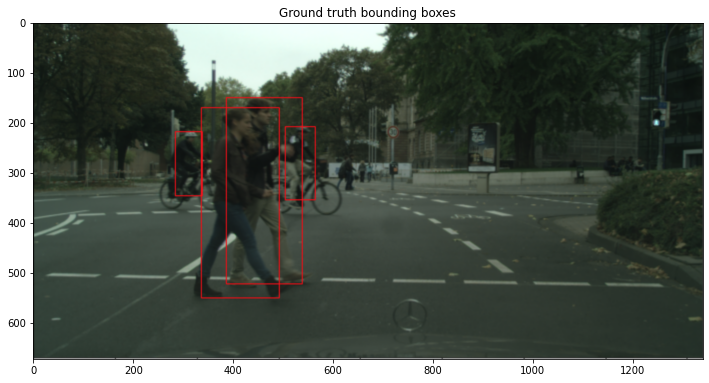

In [6]:
img = Image.open('../figures/ground-truth.png')

plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
ax.imshow(img)   

plt.title('Ground truth bounding boxes')
plt.show()

In [ ]:
dts = dataset[0]
dts_boxes = np.array(dts[1]['boxes'])

In [ ]:
dts_boxes

In [ ]:
def convert_back(img, img_raw):
    img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    img = np.array(img)
    print('img shape: %d x %d x %d' % img.shape)
    img = Image.fromarray(np.uint8(img)).convert('RGB')

    img_flipped = np.array(img.transpose(Image.FLIP_LEFT_RIGHT))
    img_raw = np.array(img_raw)
    img_was_flipped = np.sum(img_flipped.flatten() == img_raw.flatten()) == img_flipped.shape[0] * img_flipped.shape[1] * img_flipped.shape[2]
    print('Image was flipped: %r' % img_was_flipped)
    
    return img

### Predicted

In [ ]:
def show(i, imgs, threshold=.3):
    img_name = imgs[i]
    img_path = imgs_path + img_name
    img = Image.open(img_path)
    ## np_image = np.array(img)
    img_raw = img

    idx = indices.index(i)
    img, anno = dataset[idx]

    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
        
    preds = prediction['boxes'] # predicted bboxes
    preds = preds.cpu().data.numpy() # to numpy array
    
    scores = prediction['scores'] # scores of predicted bboxes
    scores = scores.cpu().data.numpy()
    
    ## keep only bboxes where score > threshold:
    highs = list(np.where(scores > threshold)[0])
    
    img = convert_back(img, img_raw)

    bboxes_x0x1y0y1 = []
    for high in highs:
        bboxes_x0x1y0y1.append(list(preds[high]))
        
    ## transform the bboxes from tensor to list and back to [x, y, w, h] format
    ## transform back to [x, y, w, h] format
    bboxes = []
    for bbox in bboxes_x0x1y0y1:
        bbox = list(bbox)
        x0, y0 = bbox[0], bbox[1]
        x1, y1 = bbox[2], bbox[3]

        bboxes.append([x0, y0, x1 - x0, y1 - y0])
    
    ## draw the predicted bounding boxes    
    plt.rcParams['figure.figsize'] = [12, 8]

    fig, ax = plt.subplots()

    ax.imshow(img);

    # bbox = [x, y, w, h]
    for bbox in bboxes:
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], 
            linewidth=1, edgecolor='r', facecolor='none')

        ax.add_patch(rect)

    plt.title('Pedestrians detected')
    plt.show()

In [ ]:
show(0, imgs)

```
img shape: 1024 x 2048 x 3
Image was flipped: False
```

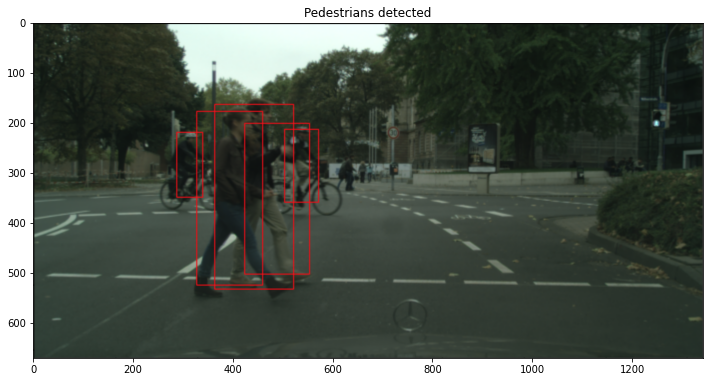

In [8]:
img = Image.open('../figures/detected-2.png')

plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
ax.imshow(img)   

plt.title('Pedestrians detected')
plt.show()